# Import Necessary Modules

In [1]:
import os , time
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from random import randint
from IPython import display

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

print("Imports done")

Imports done


/home/khaled/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read data

In [2]:
# read image file names from project directory
def readImages_fn(dir, pattern):
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    return images

vehicles_fn = readImages_fn('./training_images/vehicles/vehicles', '*.png')
non_vehicles_fn = readImages_fn('./training_images/non-vehicles/non-vehicles', '*.png')

# Visualize data

No. of     cars 8791
No. of not cars 8968


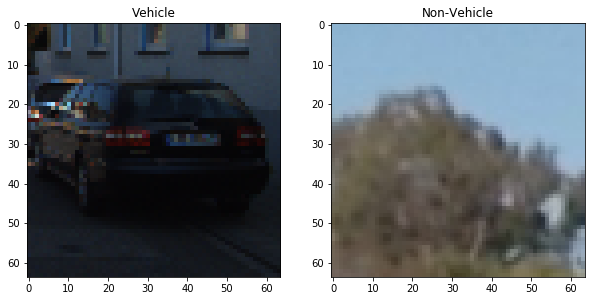

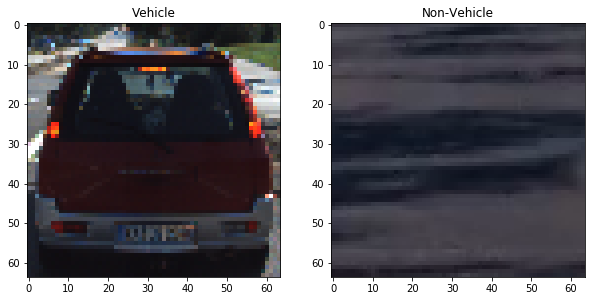

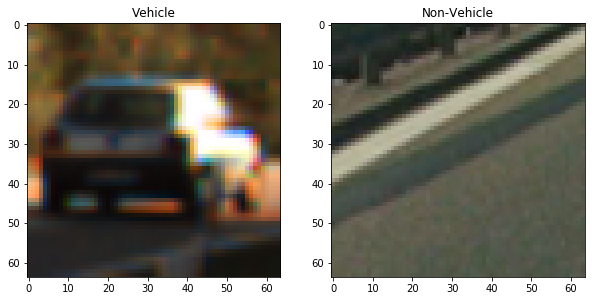

In [3]:
# Getting no. of elements in the dataset and visualize a random image in each class
cars = []
notcars = []
[cars.extend(vehicles_fn[i]) for i in range(len(vehicles_fn))]
[notcars.extend(non_vehicles_fn[i]) for i in range(len(non_vehicles_fn))]

print ("No. of     cars" ,len(cars))
print ("No. of not cars" ,len(notcars))

for i in range (3):
    sample_filename_car = cars[randint(0, len(cars)-1)]
    sample_filename_notcar = notcars[randint(0, len(notcars)-1)]
    sample_car =mpimg.imread(sample_filename_car)
    sample_notcar =mpimg.imread(sample_filename_notcar)
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(sample_car)
    axes[0].set_title('Vehicle')
    axes[1].imshow(sample_notcar)
    axes[1].set_title('Non-Vehicle')

# Features extraction functions

In [4]:
# # Define a function to compute HOG features 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# # Define a function to compute the spacial features 
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# # Define a function to compute color histogram features 
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# HOG visualization

/home/khaled/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


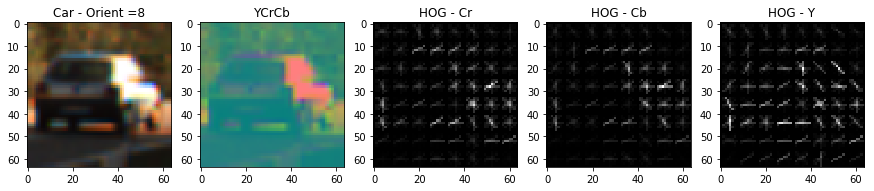

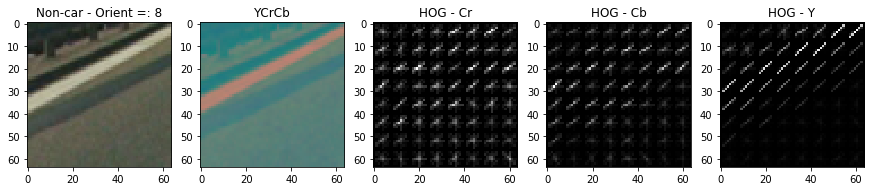

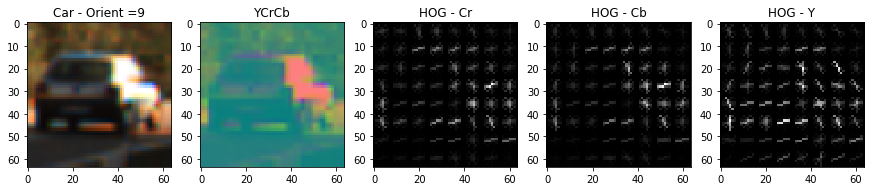

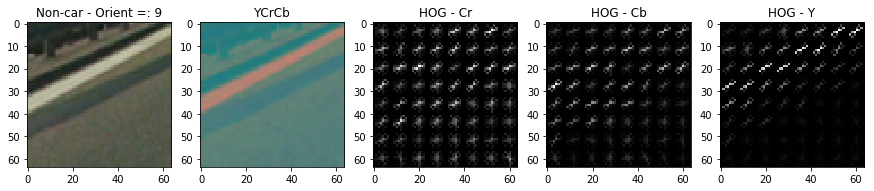

In [5]:
# visualize HOG (Histogram of Oriented Gradients)
#in YCrCb color space using certain HOG parameters
orient_param_test=[8,9]
pix_per_cell_param=8
cells_per_block_param=2

def visualizeHOG(img, title):
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

#def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    _, hog_y = get_hog_features(img_cspaced[:,:,0],orient_param, pix_per_cell_param, cells_per_block_param, vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1],orient_param, pix_per_cell_param, cells_per_block_param, vis=True, feature_vec=True)
    _, hog_Cb = get_hog_features(img_cspaced[:,:,2],orient_param, pix_per_cell_param, cells_per_block_param, vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=5, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(img_cspaced)
    axes[1].set_title("YCrCb")
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')
    axes[4].imshow(hog_y, cmap='gray')
    axes[4].set_title('HOG - Y')
    
for orient_param in orient_param_test:
    visualizeHOG(sample_car, 'Car - Orient =' + str(orient_param))
    visualizeHOG(sample_notcar, 'Non-car - Orient =: ' + str(orient_param))

# Features extraction Main function

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
#        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Features extraction paramaters

In [7]:
color_space_param='YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size_param=(32, 32) # Spatial binning dimensions
hist_bins_param=32 # 16    # Number of histogram bins
orient_param=9
pix_per_cell_param=8  #HOG
cell_per_block_param=2  # HOG
hog_channel_param= 'ALL' # # Can be 0, 1, 2, or "ALL"

# Detection extraction parameters

In [8]:
ystart = 400
ystop = 656
scale = 1.5
Movie_History_length = 8
heat_threshold_param = 1

# Training

In [9]:
print ("cars", len(cars))
cars_and_flipped = []
notcars_and_flipped = []
for car in cars:
    image = mpimg.imread(car)
    cars_and_flipped.append(image)
    cars_and_flipped.append(cv2.flip(image,1))
for notcar in notcars:
    image = mpimg.imread(notcar)
    notcars_and_flipped.append(image)
    notcars_and_flipped.append(cv2.flip(image,1))

car_features = extract_features(cars_and_flipped, color_space=color_space_param, 
                        spatial_size=spatial_size_param, hist_bins=hist_bins_param, 
                        orient=orient_param, pix_per_cell=pix_per_cell_param, 
                        cell_per_block=cell_per_block_param, 
                        hog_channel=hog_channel_param)
notcar_features = extract_features(notcars_and_flipped, color_space=color_space_param, 
                        spatial_size=spatial_size_param, hist_bins=hist_bins_param, 
                        orient=orient_param, pix_per_cell=pix_per_cell_param, 
                        cell_per_block=cell_per_block_param, 
                        hog_channel=hog_channel_param)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
#print ("all data" ,y)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

#print ("train",y_train)
   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient_param,'orientations',pix_per_cell_param,
    'pixels per cell and', cell_per_block_param,'cells per block')
print("color_space_param:",color_space_param ,", spatial_size_param:",spatial_size_param)
print("hog_channel_param:" ,hog_channel_param)
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

cars 8791


/home/khaled/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
color_space_param: YCrCb , spatial_size_param: (32, 32)
hog_channel_param: ALL
Feature vector length: 8460
15.85 Seconds to train SVC...


In [10]:
# Check the score of the SVC
n_predict=1000
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
predicted=svc.predict(X_test[0:n_predict])
#print('My SVC predicts: ',predicted )
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])
no=0.0
t=time.time()
for i in range (n_predict):
    if predicted[i] ==y_test[i]:
        no+=1.0
t2=time.time()
print ("Test accuracy on first 1000 images ",no*100/n_predict , "%" )
print ("Average prediction time: ", (round(t2-t, 3)), "Micro Seconds to predict a single image" )

Test Accuracy of SVC =  0.9935
Test accuracy on first 1000 images  99.0 %
Average prediction time:  0.003 Micro Seconds to predict a single image


In [11]:
pickle.dump( { 'svc': svc, 'X_scaler': X_scaler }, open('./model_flipped.p', 'wb'))

# Help functions for testing

In [12]:
import numpy as np
import cv2
from skimage.feature import hog
dist_pickle = pickle.load( open( "./model_flipped.p", "rb" ) )
svc = dist_pickle["svc"]; 
X_scaler = dist_pickle["X_scaler"]

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Main functions for testing

6


/home/khaled/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


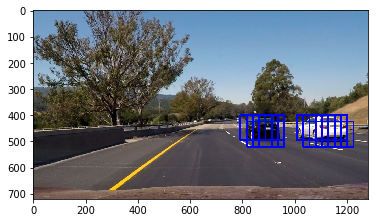

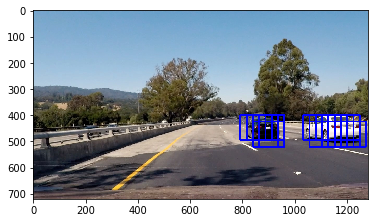

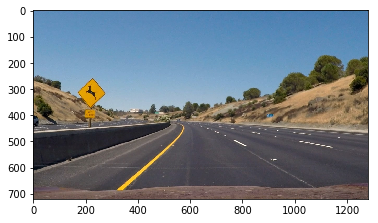

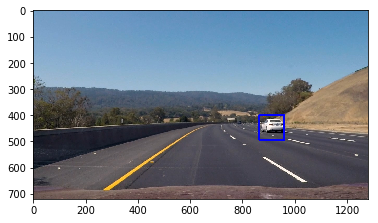

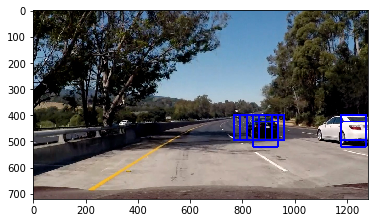

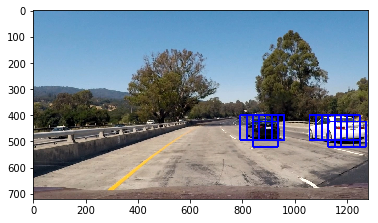

In [13]:
test_images_fn = glob.glob('./test_images/*.jpg')
print (len(test_images_fn))

test_images = []
[test_images.append(mpimg.imread(image_fn)) for image_fn in test_images_fn]


orient = orient_param
pix_per_cell = pix_per_cell_param
cell_per_block = cell_per_block_param
spatial_size = spatial_size_param
hist_bins = hist_bins_param


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') #conv='RGB2YUV') #
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    boxlist=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)

                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxlist.append(((int(xbox_left),int(ytop_draw+ystart)),
                               (int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return draw_img, boxlist
    
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# image = mpimg.imread('test_images/test1.jpg')
# plt.imshow(image)
# out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

for image in test_images:
    out_img,boxlist = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    display.display(plt.gcf())
    plt.imshow(out_img)

/home/khaled/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


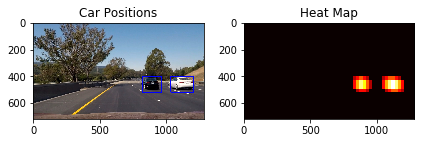

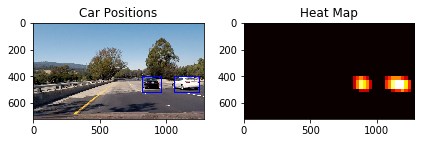

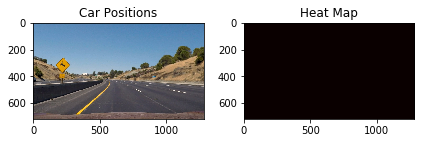

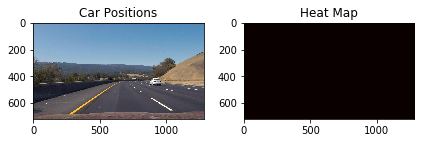

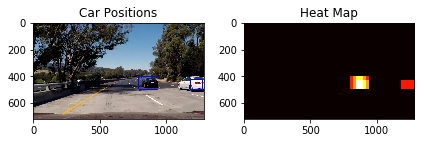

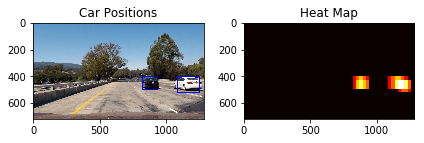

In [14]:

from scipy.ndimage.measurements import label
from collections import deque
history = deque(maxlen = 8)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



def main_pipeline(img):
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxlist)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap_current = np.clip(heat, 0, 255)
    history.append(heatmap_current)
    heatmap = np.zeros_like(heatmap_current).astype(np.float)
    for heat in history:
        heatmap=heatmap+heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return  draw_img

for image in test_images:
#    draw_img=main_pipeline(image)
         

    out_img,boxlist = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxlist)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold_param)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
#     display.display(plt.gcf())
#     plt.imshow(draw_img)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [15]:

def main_pipeline(img):
    out_img,boxlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxlist)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap_current = np.clip(heat, 0, 255)
    history.append(heatmap_current)
    heatmap = np.zeros_like(heatmap_current).astype(np.float)
    for heat in history:
        heatmap=heatmap+heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

history = deque(maxlen = Movie_History_length)
project_video_output="./video_output/video_flipped.mp4"

clip1 = VideoFileClip("project_video.mp4")#.subclip(30,)
video_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./video_output/video_flipped.mp4
[MoviePy] Writing video ./video_output/video_flipped.mp4


100%|█████████▉| 1260/1261 [17:58<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_output/video_flipped.mp4 

CPU times: user 20min 4s, sys: 6.18 s, total: 20min 11s
Wall time: 17min 59s
